In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from typing import List

from sklearn.preprocessing import LabelEncoder

%matplotlib inline

## Считаем данные соревнования от MTS по RecSys

In [2]:
df = pd.read_csv("interactions.csv")
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [3]:
df.user_id.nunique(), df.item_id.nunique()

(962179, 15706)

In [4]:
df.last_watch_dt.min(), df.last_watch_dt.max()

('2021-03-13', '2021-08-22')

In [5]:
df["last_watch_dt"] = pd.to_datetime(df["last_watch_dt"]) - pd.to_datetime(df["last_watch_dt"]).min()
df["last_watch_dt"] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
4032774,1036382,3734,131,5420,99.0
3457373,143286,4151,158,42,0.0
1860952,431079,8134,131,606,100.0
5379920,444338,10440,97,51334,90.0
5387072,1017803,9811,63,7215,100.0


## Popular bias

<AxesSubplot: xlabel='index'>

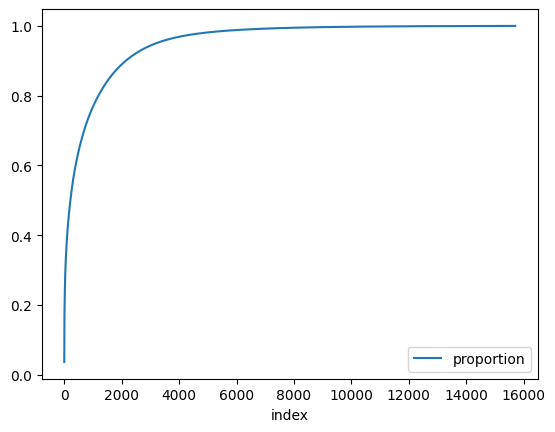

In [6]:
g = df.item_id.value_counts(True).cumsum().reset_index().reset_index()
g.plot(x="index", y="proportion")

<AxesSubplot: xlabel='index'>

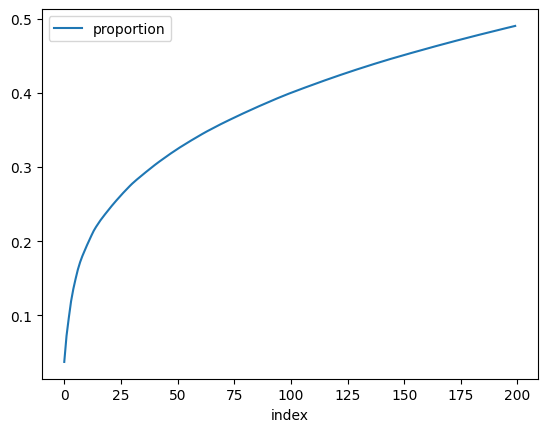

In [7]:
g = df.item_id.value_counts(True)[:200].cumsum().reset_index().reset_index()
g.plot(x="index", y="proportion")

## Популярность айтема по времени

<AxesSubplot: >

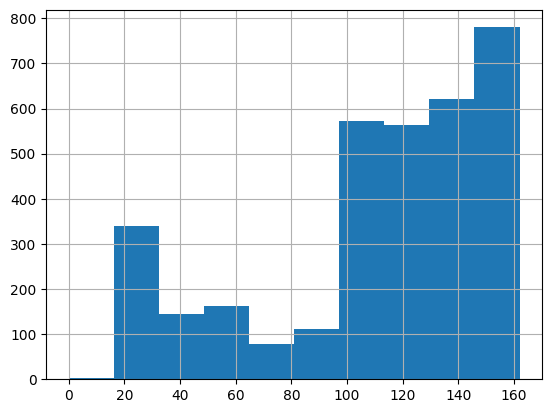

In [8]:
popular_items = df.item_id.value_counts()[:300].index.tolist()

sampled_id = np.random.choice(popular_items)

interactions = df.loc[df.item_id == sampled_id].copy()
interactions.last_watch_dt.hist()

In [9]:
temp = df.groupby("item_id").agg({"last_watch_dt": "max"}).reset_index()
temp = temp.loc[temp.item_id.isin(popular_items)].copy()
temp = temp.sort_values(by="last_watch_dt")
temp.head()

,item_id,last_watch_dt
6751,7107,87
8359,8801,140
11826,12463,141
4486,4716,141
14,14,162


<AxesSubplot: >

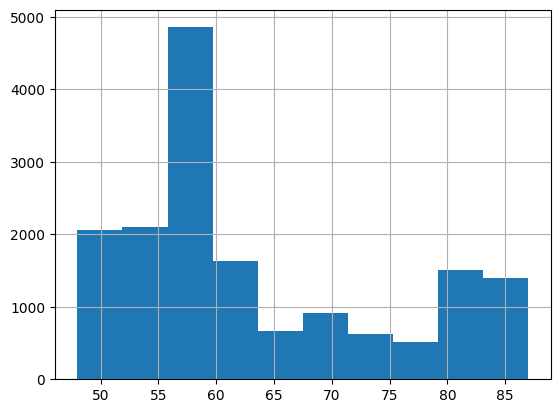

In [10]:
interactions = df.loc[df.item_id == 7107].copy()
interactions.last_watch_dt.hist()

этот айтем не встретится в тесте скорее всего, хоть он и популярный

## Сделаем протокол тестирования

<AxesSubplot: >

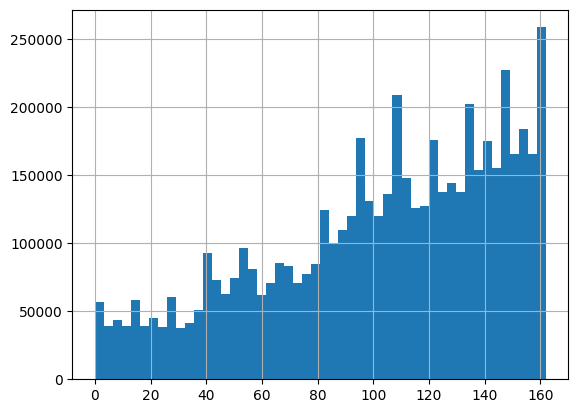

In [11]:
df.last_watch_dt.hist(bins=50)

In [12]:
train_df = df[(df.last_watch_dt < 160 - 7)]
test_df = df[(df.last_watch_dt >= 160 - 7)]

train_users = train_df.user_id.unique()
train_items = train_df.item_id.unique()

test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

old_shape = test_df.shape[0]
print(f"Размер тестовой выборки до фильтрации: {old_shape}")
test_df = test_df[test_df.user_id.isin(train_users)]
test_df = test_df[test_df.item_id.isin(train_items)]


test_users = test_df.user_id.unique()
all_included = np.intersect1d(train_users, test_users)
print(
    f"Размер тестовой выборки после фильтрации: {test_df.shape[0]} (было удалено {old_shape - test_df.shape[0]} строк или {100 * (old_shape - test_df.shape[0]) / old_shape:.2f}%)"
)
print(f"Число уникальных пользователей в тестовой выборке: {test_df.user_id.nunique()}")

Размер тестовой выборки до фильтрации: 608469
Размер тестовой выборки после фильтрации: 404241 (было удалено 204228 строк или 33.56%)
Число уникальных пользователей в тестовой выборке: 132257


## Теперь переведем к соединенному датасету все

In [13]:
n_users = 50_000

all_included = np.random.choice(all_included, size=n_users, replace=False)
print(len(all_included))
train_df = train_df[train_df.user_id.isin(all_included)]
test_df = test_df[test_df.user_id.isin(all_included)]

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users
test_df = test_df[test_df.user_id.isin(train_df.user_id.unique())]
test_df = test_df[test_df.item_id.isin(train_df.item_id.unique())]

50000


In [14]:
train_grouped = (
    train_df.groupby("user_id")
    .apply(lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, x.last_watch_dt), key=lambda x: x[1])])
    .reset_index()
)
train_grouped.rename({0: "train_interactions"}, axis=1, inplace=True)

test_grouped = (
    test_df.groupby("user_id")
    .apply(lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, x.last_watch_dt), key=lambda x: x[1])])
    .reset_index()
)
test_grouped.rename({0: "test_interactions"}, axis=1, inplace=True)

train_grouped.head()

,user_id,train_interactions
0,3,"[(2657, 82), (3734, 131), (9728, 132), (10440,..."
1,21,"[(10283, 7), (15997, 15), (12261, 17), (4345, ..."
2,47,"[(13361, 138), (13865, 138), (7401, 142), (129..."
3,120,"[(15297, 151), (6809, 151), (1000, 151)]"
4,136,"[(2720, 132), (3800, 141)]"


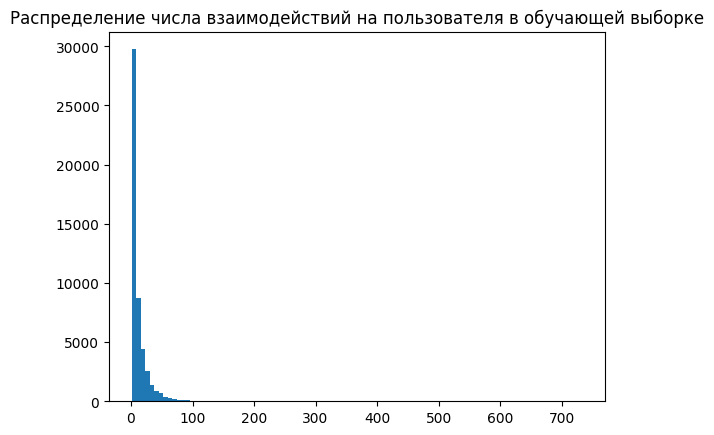

count    50000.00000
mean        12.16434
std         18.75366
min          1.00000
25%          3.00000
50%          6.00000
75%         14.00000
max        734.00000
Name: train_interactions, dtype: float64

In [15]:
plt.hist(train_grouped["train_interactions"].apply(len), bins=100)
plt.title("Распределение числа взаимодействий на пользователя в обучающей выборке")
plt.show()
train_grouped["train_interactions"].apply(len).describe()

In [16]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,3,"[(2657, 82), (3734, 131), (9728, 132), (10440,...","[(142, 153), (10240, 156), (965, 156), (47, 15..."
1,21,"[(10283, 7), (15997, 15), (12261, 17), (4345, ...","[(13787, 158), (14488, 158)]"
2,47,"[(13361, 138), (13865, 138), (7401, 142), (129...","[(14488, 160)]"
3,120,"[(15297, 151), (6809, 151), (1000, 151)]","[(10440, 157), (13865, 157)]"
4,136,"[(2720, 132), (3800, 141)]","[(5294, 161), (9728, 161)]"


In [17]:
def ndcg_metric(gt_items, predicted):

    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)

    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores):
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )


def recall_metric(gt_items, predicted):

    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt


def evaluate_recommender(df, model_preds, gt_col="test_interactions", topn=10):

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        metric_values.append((ndcg_metric(gt_items, row[model_preds]), recall_metric(gt_items, row[model_preds])))

    return {"ndcg": np.mean([x[0] for x in metric_values]), "recall": np.mean([x[1] for x in metric_values])}

In [18]:
def get_metrics(df, model_preds, gt_col="test_interactions", topn=10):

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        metric_values.append((ndcg_metric(gt_items, row[model_preds]), recall_metric(gt_items, row[model_preds])))

    return metric_values

In [19]:
class TopPopular:
    def __init__(self):

        self.trained = False

    def fit(self, df, col="train_interactions"):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=100) -> List[np.ndarray]:

        assert self.trained

        all_recs = []

        for idx, row in df.iterrows():

            user_recs = []

            user_interactions = set([x[0] for x in row["train_interactions"]])

            for elem in self.recommenations:
                if elem not in user_interactions:
                    user_recs.append(elem)

                if len(user_recs) == topn:
                    break

            all_recs.append(user_recs)

        return all_recs


toppop = TopPopular()
toppop.fit(joined)

joined["toppopular_recs"] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,toppopular_recs
0,3,"[(2657, 82), (3734, 131), (9728, 132), (10440,...","[(142, 153), (10240, 156), (965, 156), (47, 15...","[15297, 13865, 142, 9996, 8636, 6809, 7829, 75..."
1,21,"[(10283, 7), (15997, 15), (12261, 17), (4345, ...","[(13787, 158), (14488, 158)]","[15297, 9728, 3734, 4151, 4880, 2657, 142, 999..."
2,47,"[(13361, 138), (13865, 138), (7401, 142), (129...","[(14488, 160)]","[10440, 15297, 9728, 3734, 4151, 4880, 2657, 1..."
3,120,"[(15297, 151), (6809, 151), (1000, 151)]","[(10440, 157), (13865, 157)]","[10440, 9728, 13865, 3734, 4151, 4880, 2657, 1..."
4,136,"[(2720, 132), (3800, 141)]","[(5294, 161), (9728, 161)]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."


In [20]:
evaluate_recommender(joined, model_preds="toppopular_recs")

{'ndcg': 0.48970274722663365, 'recall': 0.37645140301035773}

## Теперь выкинем айтемы, которые не показывались в момент перед тестом

In [21]:
ld = train_df.groupby("item_id").agg({"last_watch_dt": "max"}).reset_index()
validated_items = ld.loc[ld.last_watch_dt == 152].item_id.unique()

# validated_items

In [22]:
ld.max()

item_id          16516
last_watch_dt      152
dtype: int64

In [23]:
class ActualTopPopular(TopPopular):
    def __init__(self):

        self.trained = False

    def predict(self, df, only_items=None, topn=100) -> List[np.ndarray]:

        assert self.trained

        only_items = set(only_items)

        all_recs = []

        for idx, row in df.iterrows():

            user_recs = []

            user_interactions = set([x[0] for x in row["train_interactions"]])

            for elem in self.recommenations:
                if elem not in user_interactions and elem in only_items:
                    user_recs.append(elem)

                if len(user_recs) == topn:
                    break

            all_recs.append(user_recs)

        return all_recs


toppop = ActualTopPopular()
toppop.fit(joined)
joined["actual_toppop"] = toppop.predict(joined, only_items=validated_items)
joined.head()

,user_id,train_interactions,test_interactions,toppopular_recs,actual_toppop
0,3,"[(2657, 82), (3734, 131), (9728, 132), (10440,...","[(142, 153), (10240, 156), (965, 156), (47, 15...","[15297, 13865, 142, 9996, 8636, 6809, 7829, 75...","[15297, 13865, 142, 9996, 8636, 6809, 7829, 75..."
1,21,"[(10283, 7), (15997, 15), (12261, 17), (4345, ...","[(13787, 158), (14488, 158)]","[15297, 9728, 3734, 4151, 4880, 2657, 142, 999...","[15297, 9728, 3734, 4151, 4880, 2657, 142, 999..."
2,47,"[(13361, 138), (13865, 138), (7401, 142), (129...","[(14488, 160)]","[10440, 15297, 9728, 3734, 4151, 4880, 2657, 1...","[10440, 15297, 9728, 3734, 4151, 4880, 2657, 1..."
3,120,"[(15297, 151), (6809, 151), (1000, 151)]","[(10440, 157), (13865, 157)]","[10440, 9728, 13865, 3734, 4151, 4880, 2657, 1...","[10440, 9728, 13865, 3734, 4151, 4880, 2657, 1..."
4,136,"[(2720, 132), (3800, 141)]","[(5294, 161), (9728, 161)]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."


In [24]:
evaluate_recommender(joined, model_preds="actual_toppop")

{'ndcg': 0.49264188872872966, 'recall': 0.379082586310133}

### ALS

Итак, поставлена задача построения модели со скрытыми переменными (latent factor model) для коллаборативной фильтрации:

$$\sum_{u,i} (r_{ui} - \langle p_u, q_i \rangle)^2 \to \min_{P,Q}. $$

Напомним, что суммирование ведется по всем парам $(u, i),$ для которых известен рейтинг $r_{ui}$ (и только по ним), а $p_u, q_i$ – латентные представления пользователя $u$ и товара $i$ из соответствующих матрицы $P, Q$.

Подход ALS (Alternating Least Squares) решает задачу, попеременно фиксируя матрицы $P$ и $Q$, — оказывается, что, зафиксировав одну из матриц, можно выписать аналитическое решение задачи для другой.

$$\nabla_{p_u} \bigg[ \sum_{u,i} (r_{ui} - \langle p_u, q_i \rangle)^2 \bigg] = \sum_{i} 2(r_{ui} - \langle p_u, q_i \rangle)q_i = 0$$

Воспользовавшись тем, что $a^Tbc = cb^Ta$, получим
$$\sum_{i} r_{ui}q_i - \sum_i q_i q_i^T p_u = 0.$$
Тогда окончательно каждый столбец матрицы $P$ можно найти по формуле
$$p_u = \bigg( \sum_i q_i q_i^T\bigg)^{-1}\sum_ir_{ui}q_i \;\; \forall u,$$
аналогично для столбцов матрицы $Q$
$$q_i = \bigg( \sum_u p_u p_u^T\bigg)^{-1}\sum_ur_{ui}p_u \;\; \forall i.$$

Таким образом мы можем решать оптимизационную задачу, поочередно фиксируя одну из матриц $P$ или $Q$ и проводя оптимизацию по второй.

**Оригинальная статья (для explicit feedback):**

Bell, R.M. and Koren, Y., 2007, October. Scalable collaborative filtering with jointly derived neighborhood interpolation weights. In Seventh IEEE international conference on data mining (ICDM 2007) (pp. 43-52). IEEE.


### iALS


**Статья для implicit данных:**


Implicit feedback ALS:
* Hu, Y., Koren, Y. and Volinsky, C., 2008, December. Collaborative filtering for implicit feedback datasets. In 2008 Eighth IEEE international conference on data mining (pp. 263-272). Ieee. http://yifanhu.net/PUB/cf.pdf

**Особенности:**

1. Нет explicit данных (явных позитивных и отрицательных оценок). <br>
2. Много шума в данных.  <br>
3. Используются свои функции и метрики для оценки implicit feedback. Если в explicit $r_ui$ - это оценки предпочтений пользователя, то в implicit - это степень уверенности. <br>

Наша задача оптимизации в том, что мы стремимся минимизировать целевую функцию и найти
оптимальные $X$ и $Y$. В частности, мы стремимся минимизировать ошибку наименьших квадратов наблюдаемых оценок
(и упорядочить):

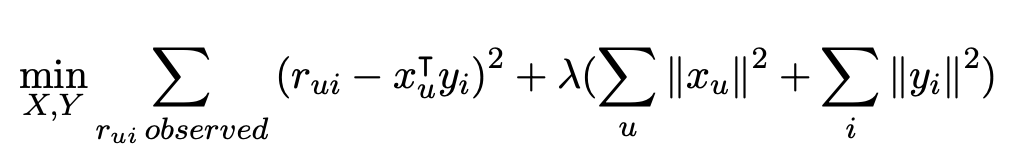  

Для implicit feedback:

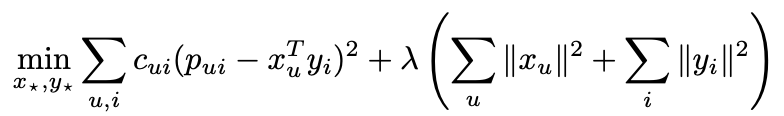  

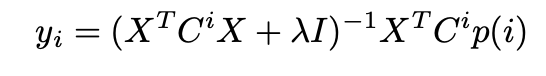


Авторы статьи вводят набор переменных, $c_ui$, которые измеряют нашу уверенность в наблюдении за $p_ui$. Чем больше значение наблюдения за пользовательским элементом, тем больше вы уверены в этом значении. Таким образом, у нас есть некоторая минимальная уверенность в $p_ui$ для каждой пары пользовательских элементов, но по мере того, как мы наблюдаем больше положительных предпочтений по паре пользователь-объект, наша уверенность в $p_ui$ = 1 соответственно возрастает. Скорость увеличения регулируется константой $\alpha$.

<img src='https://raw.githubusercontent.com/anamarina/RecSys_course/main/week2/images/als.png' width=700 height=500>



| Критерий | ALS  |  iALS | 
|---|---|---|
| Тип данных | Этот подход используется, когда у вас есть явные рейтинги или оценки, предоставленные пользователями для различных предметов. Например, пользователи могут оценивать фильмы по шкале от 1 до 5. |  Этот подход используется, когда у вас есть неявные сигналы взаимодействия между пользователями и предметами, такие как клики, просмотры, покупки или временные интервалы между действиями. |  
|
|Цель | Модель стремится точно предсказать явные рейтинги или оценки, которые пользователи могли бы дать предметам. | Модель стремится моделировать уровень уверенности или важности взаимодействия между пользователем и предметом, но не предсказывает явные рейтинги.|  
|
|Функции потерь| Обычно использует функцию потерь, такую как среднеквадратичная ошибка (MSE), для минимизации разницы между предсказанными и фактическими оценками. | Использует функцию потерь, которая учитывает уверенность в неявных взаимодействиях и стремится увеличить уверенность для более важных взаимодействий.| 
|
|Взвешивание| Не уделяет внимания взаимодействиям, которые не были явно оценены пользователями. Исключает информацию о неявных действиях. | Дополнительная параметризация. Учитывает все неявные действия, но с учетом их уверенности или веса, что позволяет модели учесть важность различных видов взаимодействий| 
|

In [24]:
from sklearn.metrics import mean_squared_error


class NaiveALS:
    def __init__(self, n_iters, n_factors, reg):
        self.reg = reg
        self.n_iters = n_iters
        self.n_factors = n_factors

    def fit(self, train: pd.DataFrame, test: pd.DataFrame):
        n_users = train["user_id"].nunique()
        m_items = train["item_id"].nunique()

        user_encoder = LabelEncoder()
        item_encoder = LabelEncoder()

        encoded_users = user_encoder.fit_transform(train_df["user_id"].values)
        encoded_item = item_encoder.fit_transform(train_df["item_id"].values)

        train_ratings = np.zeros((n_users, m_items))
        train_ratings[encoded_users, encoded_item] = 1

        self.P = np.random.rand(n_users, self.n_factors)
        self.Q = np.random.rand(m_items, self.n_factors)

        for i in range(self.n_iters):
            self.P = self._als_step(train, self.P, self.Q)
            self.Q = self._als_step(train.T, self.Q, self.P)
            predictions = self.predict()
            train_mse = self.compute_mse(train, predictions)
            print(f"loss on {i} step: {train_mse}")

    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.n_factors) * self.reg
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs

    def predict(self):
        pred = self.user_factors.dot(self.item_factors.T)
        return pred

    @staticmethod
    def compute_mse(y_true, y_pred):
        mask = np.nonzero(y_true)
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        return mse

In [25]:
!pip install implicit

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [26]:
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking

from tqdm.auto import tqdm


class ImplicitModel:
    def __init__(self, model):
        self.model = model
        self.trained = False

    def fit(self, train_df: pd.DataFrame):
        self.item_encoder = LabelEncoder()
        self.user_encoder = LabelEncoder()
        self.item_encoder.fit(train_df.item_id)
        self.user_encoder.fit(train_df.user_id)

        self.train_ratings = self.encode_table(train_df, ["user_id", "item_id"])
        self.model.fit(self.train_ratings)
        self.trained = True

    def predict(self, test_df: pd.DataFrame, top_k: int = 100):
        if not self.trained:
            raise ValueError("Model is not fitted. Please, fit the model first")
        users_to_predict = test_df.user_id
        encoded_users = self.user_encoder.transform(users_to_predict)
        user_recs = self.model.recommend(
            encoded_users, self.train_ratings[encoded_users], N=top_k, filter_already_liked_items=True
        )[0]
        recs = [self.item_encoder.inverse_transform(x) for x in user_recs]
        return recs

    def encode_table(
        self,
        df: pd.DataFrame,
        axis_names: List[str],
    ) -> np.ndarray:
        user_ids = self.user_encoder.transform(df[axis_names[0]])
        item_ids = self.item_encoder.transform(df[axis_names[1]])

        matrix_shape = len(self.user_encoder.classes_), len(self.item_encoder.classes_)

        sparse = csr_matrix((np.ones(len(user_ids)), (user_ids, item_ids)), shape=matrix_shape, dtype=np.float32)

        return sparse

In [41]:
als = AlternatingLeastSquares(iterations=3, factors=32, regularization=0.01, calculate_training_loss=True)
als_recommender = ImplicitModel(als)
als_recommender.fit(train_df)

  0%|          | 0/3 [00:00<?, ?it/s]

In [42]:
preds = als_recommender.predict(joined, top_k=10)
joined["als_recs"] = preds
evaluate_recommender(joined, model_preds="als_recs")

{'ndcg': 0.1107979293816422, 'recall': 0.06815840771390895}

In [43]:
joined[["als_recs", "actual_toppop"]]

,als_recs,actual_toppop
0,"[14431, 7102, 5434, 6162, 7571, 12995, 4457, 8...","[15297, 13865, 142, 9996, 8636, 6809, 7829, 75..."
1,"[14431, 4880, 4740, 4436, 12981, 12324, 14703,...","[15297, 9728, 3734, 4151, 4880, 2657, 142, 999..."
2,"[4495, 7793, 16228, 1449, 14317, 5693, 12192, ...","[10440, 15297, 9728, 3734, 4151, 4880, 2657, 1..."
3,"[14317, 6192, 16228, 11778, 13018, 4716, 16166...","[10440, 9728, 13865, 3734, 4151, 4880, 2657, 1..."
4,"[12192, 101, 2657, 9996, 4740, 14470, 10878, 3...","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
...,...,...
49958,"[1916, 12981, 14703, 4740, 3076, 9194, 12463, ...","[13865, 3734, 4151, 4880, 2657, 9996, 8636, 12..."
49959,"[12981, 7102, 4740, 14703, 5250, 14741, 10464,...","[10440, 15297, 9728, 3734, 4151, 4880, 2657, 1..."
49960,"[12192, 14317, 7793, 4457, 101, 1287, 11237, 4...","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
49961,"[7626, 8636, 14741, 10942, 11237, 7417, 7793, ...","[10440, 15297, 13865, 4151, 2657, 142, 9996, 8..."


In [30]:
user_id = 0
item_id = 42

als_recommender.model.explain(user_id, als_recommender.train_ratings[user_id], item_id)

(0.0022601978679605166,
 [(6219, 0.0005368269626411277),
  (2392, 0.0003404251870019632),
  (3103, 0.0002134137648068045),
  (6666, 0.00017849792950986573),
  (2657, 0.0001410165086725532),
  (1697, 0.00013471646656506176),
  (2837, 0.00012452149050015308),
  (7805, 8.825598688757474e-05),
  (6680, 8.660177075386799e-05),
  (901, 4.832147658440955e-05)],
 (array([[ 7.15355655,  1.24460747,  1.3121567 ,  1.32487052,  1.29690443,
           1.44090151,  1.22688874,  1.22673556,  1.30192359,  1.23592228,
           1.31355944,  1.15487587,  1.20749785,  1.27380712,  1.22465785,
           1.18757503],
         [ 8.9033699 ,  7.11936123,  0.9575699 ,  1.07008164,  1.02942984,
           0.85294902,  0.89402622,  1.09732763,  0.94587682,  1.04081531,
           1.07118003,  1.09301731,  1.05114254,  0.83957497,  0.9397367 ,
           0.8787824 ],
         [ 9.38658714,  8.45040607,  7.16166219,  0.89980396,  1.0631984 ,
           1.58358048,  1.18702971,  0.87900899,  1.22487892,  0.96650

<AxesSubplot: >

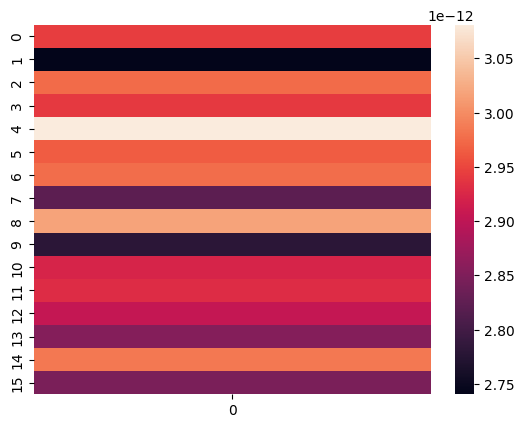

In [36]:
sns.heatmap(als_recommender.model.user_factors[0].reshape(-1, 1))

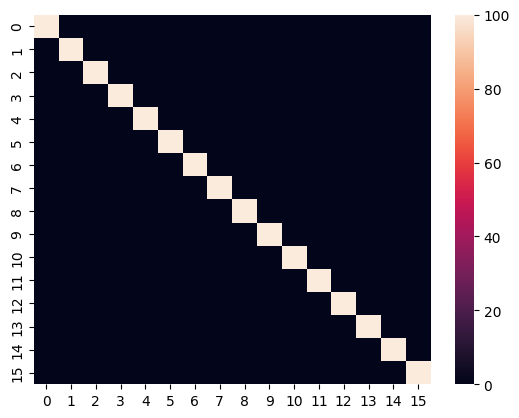

[(6666, 3.5840073144914887e-29),
 (6219, 3.0063600647835145e-29),
 (2657, 2.3106031659725696e-29),
 (2392, 2.2344804921793126e-29),
 (3103, 1.8564603108459472e-29),
 (1697, 1.6331303180521187e-29),
 (7805, 1.146489731266984e-29),
 (2837, 5.399334131660368e-30),
 (6680, 4.438813597900415e-30),
 (901, 2.2829725645434205e-30)]

In [32]:
import seaborn as sns

user_id = 0
item_id = 42

sns.heatmap(als_recommender.model.explain(user_id, als_recommender.train_ratings[user_id], item_id, N=10)[2][0])
plt.show()
als_recommender.model.explain(user_id, als_recommender.train_ratings[user_id], item_id, N=10)[1]

In [44]:
bpr = BayesianPersonalizedRanking(
    iterations=7,
    factors=16,
    regularization=0.001,
    learning_rate=0.001,
)
bpr_recommender = ImplicitModel(bpr)
bpr_recommender.fit(train_df)

  0%|          | 0/7 [00:00<?, ?it/s]

In [45]:
preds = bpr_recommender.predict(joined, top_k=10)
joined["bpr_recs"] = preds
evaluate_recommender(joined, model_preds="bpr_recs")

{'ndcg': 0.23501424254068656, 'recall': 0.1642022807947956}

### Доп. материалы

Есть **Weighted Matrix Factorization** (взвешенная матричная факторизация), которая раскладывает целевую функцию на две суммы:

1) сумма по всем имеющимся интеракциям

2) сумма по отсутствующим интеракциям (которые мы обозначали 0)


$$min_{P \in R^{m\times d}, Q \in R^{n\times d}} \sum_{(i,j) \in obs} (A_{ij} - <P_i, Q_j>)^2 + w_{0} \cdot \sum_{(i,j) \notin obs} (<P_{i}, Q_{j}>)^2$$

Здесь $w_{0}$ — гиперпараметр, который взвешивает две компонентны, чтобы одна не преобладала над другой. Настройка этого гиперпараметра очень важна.

На практике, вам также необходимо взвешивать наблюдаемые пары. Например, частые элементы (очень популярные видео на YouTube) или слишком активные пользователи могут доминировать в целевой функции. Вы можете скорректировать этот эффект, взвесив обучающие примеры, чтобы учесть их частоту в датасете. Можно заменить целевую функцию на:

$$min_{P \in R^{m\times d}, Q \in R^{n\times d}} \sum_{(i,j) \in obs} w_{i,j} \cdot (A_{ij} - <P_i, Q_j>)^2 + w_{0} \cdot \sum_{(i,j) \notin obs} (<P_{i}, Q_{j}>)^2$$


**Минимизация целевой функции**:

* SGD (stochastic gradient descent) - общеизвестный и используемый везде метод, оптимизация происходит по наблюдениям из обучающей выборки. 
* MCMC (Markov chain Monte Carlo) - сэмплирование параметров из апостериорного распределения. 
* Weighted Alternating Least Squares (WALS) - специализированный лос под обозначенную выше целевую функцию, с попеременной оптимизацией по каждому параметру при фиксированных значениях остальных параметров. 

Лосс квадратичный для обеих матриц $P$ и $Q$.  
WALS случайным образом инициализирует эмбеддинги и потом последовательно обновляет веса то одной, то второй матрицы:

1) Фиксируем $P$, делаем итерацию оптимизации для решения $Q$. 

2) Фиксируем $Q$, делаем итерацию оптимизации для решения $P$. 

Каждый этап может быть решен в явном виде (через решение линейной системы). Этот метод гарантированно сходится, потому что каждый шаг гарантированно уменьшает потери.



| Метод оптимизации  | Достоинства  |  Недостатки | 
|---|---|---|
|  SGD |  Гибкий в использовании, можно брать другие лоссы | Медленнее, небыстро сходится  |  
|  |  Можно распараллелить вычисления | Сложнее работать с отрицательными примерами, нужен negative sampling  |  
|  WALS |  Быстрее сходится, чем SGD | Применим только к квадратичным лоссам  | 
|  |  Легче обрабатывать отсутсвующие интеракции |  |
|   |  Можно распараллелить вычисления|  | 



## SVD 

<img src='https://www.dataminingapps.com/wp-content/uploads/2020/02/svd2.png'>

SVD, помимо скалярного произведения, включает еще смещения по пользователю $b_u$ и объекту $b_i$. Предполагается, что смещения пользователей отражают тенденцию некоторых пользователей оценивать товары выше (или ниже) среднего. То же самое касается товаров: некоторые товары обычно оцениваются выше, чем некоторые другие. Модель SVD тогда выглядит следующим образом:

$$\hat r_{u,i} = \mu + b_u + b_i + q_{i}^{T}p_{u},$$

где $\mu$ - глобальное среднее по всем оценкам в данных. Тогда задача оптимизации сводится к:

$$ \sum(r_{u,i} - \hat r_{u,i}) ^ 2 +     \lambda(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2),$$

где $\lambda$ - параметр регуляризации.

Оптимизация через стохастический градиентный спуск:

$$b_u \leftarrow b_u + \gamma (e_{ui} - \lambda b_u)$$
$$b_i \leftarrow b_i + \gamma (e_{ui} - \lambda b_i)$$  
$$p_u \leftarrow p_u + \gamma (e_{ui} \cdot q_i - \lambda p_u)$$
$$q_i \leftarrow q_i + \gamma (e_{ui} \cdot p_u - \lambda q_i),$$

где $\gamma$ - это learning rate, <br>
$e_{ui} =  r_{ui} - \hat r_{u,i} = r_{u,i} - (\mu + b_u + b_i + q_{i}^{T}p_{u})$ ошибка алгоритма на паре $(u, i)$.

### Hierarchical Alternating Least Squares

Подход ALS требует вычислений обратных матриц, что накладывает сильные ограничения на размерность скрытых переменных. Альтернативой ALS является подход HALS (Hierarchical Alternating Least Squares), в котором на каждой итерации мы решаем оптимизационную задачу относительно только одной строчки матрицы $P$ или $Q$. Выведем аналитические формулы для $k$-ой строчки матрицы $P$.

$$\frac{\partial}{\partial P_{ku}} \bigg[ \sum_{u',i} (r_{u'i} - \langle p_{u'}, q_i \rangle)^2 \bigg] = \sum_{i} 2(r_{ui} - \langle p_u, q_i \rangle)Q_{ki} = 0$$

$$\sum_{i} (r_{ui} - \sum_{s\neq k} P_{su} Q_{si} )Q_{ki} - P_{ku}\sum_i Q_{ki}^2 = 0$$

$$P_{ku} = \frac{\sum_{i} (r_{ui} - \sum_{s\neq k} P_{su} Q_{si} )Q_{ki}}{\sum_i Q_{ki}^2}$$

### Neural Collaborative Filtering

<img src='https://images.deepai.org/converted-papers/2004.12212/images/NCF.png' width=500>

Нелинейным обобщением матричных разложений является коллаборативная фильтрация с помощью нейронных сетей. Сопоставим каждому пользователю $u$ one-hot encode вектор $\alpha_u$, у которого на $u$-ом месте стоит $1$, а остальные координаты заполнены нулями, аналогично определим вектор $\beta_i$ для товара $i$. В качестве алгоритма классификации (или регрессии, в зависимости от задачи) будем использовать нейросеть, у которой два полносвязных слоя на входе: один соответствует пользователям и принимает на вход вектор $\alpha_u$, а второй соответствует товарам и принимает на вход вектор $\beta_i$. После входных полносвязных слоев соответствующие представления необходимо сконкатенировать и передать в следующие полносвязные слои. На выходе нейронной сети мы получаем предсказание $\widehat{r}_{ui}$ (на рисунке обозначено как $\widehat{y}_{ui}$), которое сравниваем с истинным ответом для заданной пары $r_{ui}$ (на рисунке обозначен как $y_{ui}$).

Несмотря на свою простоту модель обладает рядом важных достоинств:

* мы можем легко обобщить модель на случай, когда у нас есть признаки пользователей или товаров, добавив эти признаки к векторам $\alpha_u$ и $\beta_i$ соответственно (также заметим, что добавление признаков в модель позволяет частично решить проблему холодного старта);
* в зависимости от размеров выборки и природы данных мы можем адаптировать архитектуру под свои нужды, например, если у нас есть картинки в качестве признаков товаров, мы можем добавить сверточные слои в нашу нейронную сеть и обучать всю модель end-to-end.

В этой модели мы по-прежнему можем получить латентные представления пользователей и товаров. На самом деле, латентными представлениями будут столбцы матрицы весов в первых полносвязных слоях (в предположении, что мы умножаем матрицу весов на вектор признаков справа).


In [47]:
import torch
import torch.nn as nn

In [115]:
class NCF(torch.nn.Module):
    def __init__(self, n_users, m_items, n_factors, hidden_dim) -> None:
        super().__init__()
        self.n_users = n_users
        self.m_items = m_items
        self.n_factors = n_factors
        self.hidden_dim = hidden_dim

        self.user_embeddings = nn.Embedding(n_users, embedding_dim=n_factors)
        self.item_embeddings = nn.Embedding(m_items, embedding_dim=n_factors)
        self.sigmoid = nn.Sigmoid()

        # dot() -> model
        self.model = nn.Sequential(
            nn.Linear(2 * n_factors, hidden_dim),
            nn.ReLU(),
            # nn.Dropout()
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            # nn.Dropout()
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, item, user):
        user_embed = self.user_embeddings(user)
        item_embed = self.item_embeddings(item)
        concatenated = torch.cat([user_embed, item_embed], dim=-1)
        prediction = self.model(concatenated)
        prediction = self.sigmoid(prediction)
        return prediction

In [73]:
user_encoder = LabelEncoder().fit(train_df["user_id"])
item_encoder = LabelEncoder().fit(train_df["item_id"])

In [116]:
ncf_model = NCF(n_users=len(user_encoder.classes_), m_items=len(item_encoder.classes_), n_factors=16, hidden_dim=64)
ncf_model

NCF(
  (user_embeddings): Embedding(50000, 16)
  (item_embeddings): Embedding(10586, 16)
  (sigmoid): Sigmoid()
  (model): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [77]:
train_encoded_users = torch.Tensor(user_encoder.transform(train_df["user_id"].values)).long()
train_encoded_items = torch.Tensor(item_encoder.transform(train_df["item_id"].values)).long()

In [92]:
def transform(x):
    encoded = item_encoder.transform(x)
    return encoded.tolist()

In [93]:
user_interactions = train_df.groupby(["user_id"]).agg({"item_id": transform})
user_interactions

,item_id
user_id,
3,"[7805, 6219, 10512, 10084, 6666, 2228, 2657, 9..."
21,"[7847, 6939, 676, 10258, 5279, 2782, 4842, 831..."
47,"[4725, 8559, 8112, 8226, 8297, 8882]"
120,"[9822, 4352, 643]"
136,"[2435, 1735]"
...,...
1097434,"[9822, 726, 745, 4535, 4780, 324, 10538, 1195,..."
1097459,"[3939, 8098, 3499, 3954, 2430, 9874, 2588, 888..."
1097463,"[6396, 3630]"


## Achtung!!!
### Не пишите такой код в обычной жизни, он слишком неоптимальный (но зато понятный, что и нужно для обучения)
В своем коде, пожалуйста, используете `torch.Dataset` и `torch.Dataloader`

In [119]:
optimizer = torch.optim.SGD(ncf_model.parameters(), lr=1e-4)
loss = nn.BCELoss()

all_items = set(list(range(ncf_model.m_items)))

for user, item in zip(train_encoded_users, train_encoded_items):
    optimizer.zero_grad()
    # сэмплируем негативы для пользователя из айтемов, с которыми он не взаимодействовал
    seen_items = set(user_interactions.loc[user_encoder.inverse_transform([user.item()])])
    unseen_items = list(all_items - seen_items)
    neg_item = torch.Tensor([np.random.choice(unseen_items, size=1)]).long()[0][0]

    # считаем скор позитивного взаимодействия
    pos_prediction = ncf_model(item, user)
    # считаем скор негативного взаимодействия
    neg_prediction = ncf_model(neg_item, user)

    # лосс для каждого из типов взаимодействий
    cur_loss = loss(pos_prediction, torch.Tensor([1]).float())
    cur_loss += loss(neg_prediction, torch.Tensor([0]).float())

    cur_loss.backward()
    optimizer.step()